[House Price](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* 분석절차
1. EDA
  - dataframe 타입별(카테고리형/수치형) 피쳐 분류

2. 결측치 확인/피쳐삭제/채우기
  - 결측값 대체(수치형:평균 / Object형:'None')

3. 수치형 피쳐 데이터값 확인
  - target 피쳐 분리
  - unique ID 피쳐 삭제

4. 수치형 피쳐 상관분석
  - target(SalePrice)에 영향을 주는 상위 n개 피쳐에 대해서만 상관 분석
  - target(SalePrice)에 영향을 주는 상위 n개 피쳐에 대해서만 데이터 분포도(산점도) 확인

5. 수치형 피쳐 인코딩
  - 인코딩(수치형:unique[:13]

6. 수치형 정규화
  - 타켓 분포도 확인/정규화
  - 정규화/스케일 (수치형:skew[:25] 로그변환

7. Object형 시각화

8. Outlier 처리
  -아웃라이어제거(수치형:IQR) 

9. Object형 피쳐 인코딩

10. 학습모델 선정 / 평가

11. 검증 / 튜닝

## Library & API

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from scipy.stats import skew #왜도
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings(action="ignore")

%matplotlib inline

분석 데이터 로드

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/train.csv")
df_t = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/test.csv")
df_s = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/price_submission.csv")
print(df.shape)
print(df_t.shape)
print(df_s.shape)

(1460, 81)
(1459, 80)
(1459, 2)


### 1. dataframe 타입별(카테고리형/수치형) 피쳐 분류

In [4]:
def type_check(df):
    object_feature = df.dtypes[df.dtypes == 'object'].index
    #object_feature = df.select_dtypes(include = ["object"]).columns
    
    numeric_feature = df.dtypes[df.dtypes != 'object'].index
    # numeric_column = df.columns - object_column

    print(df.dtypes.value_counts())
    print("object type:",object_feature)  #숫치형->범주화/인코딩
    print("numeric type:",numeric_feature) #스케일,범주화
    return object_feature, numeric_feature

object_feature, numeric_feature = type_check(df)

object     43
int64      35
float64     3
dtype: int64
object type: Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
numeric type: Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


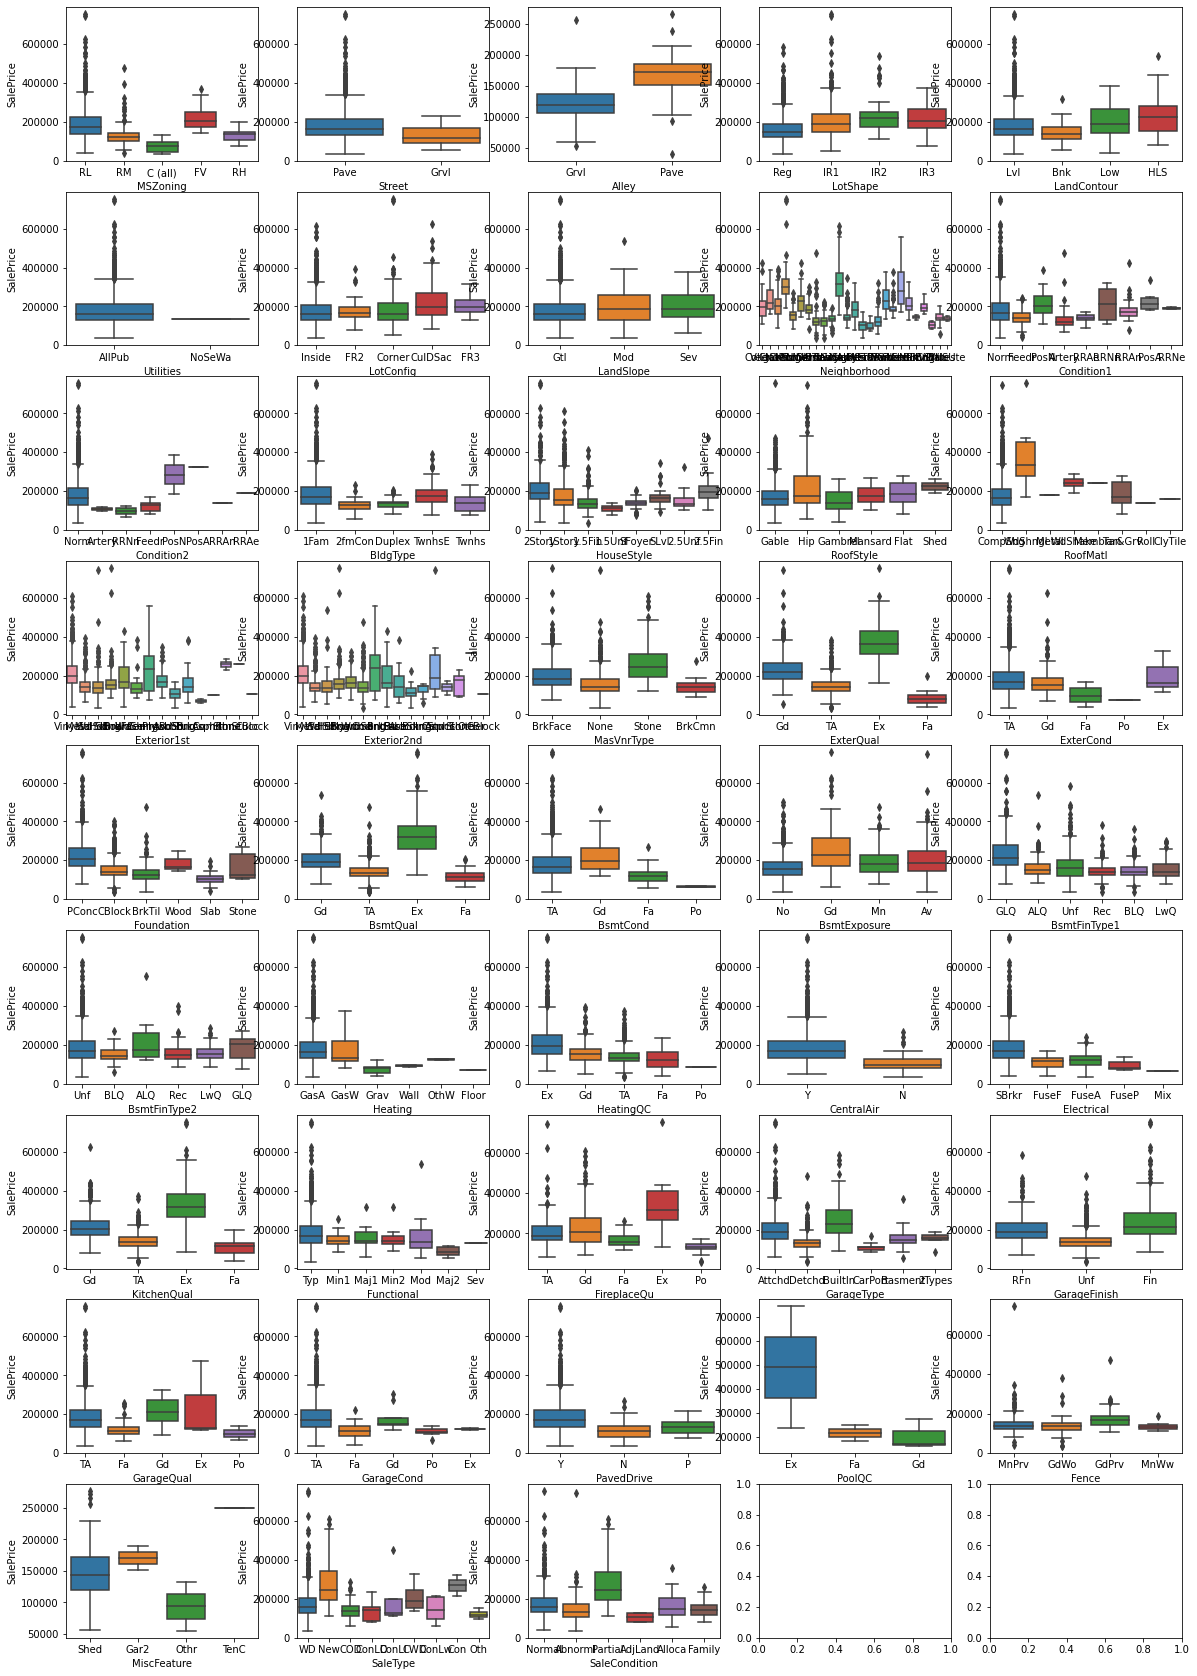

In [5]:
#============== sns.boxplot()
object_feature = df.dtypes[df.dtypes == 'object'].index
print(object_feature)
fig, axs = plt.subplots(figsize=(20,30), ncols=5, nrows=9)
for i, feature in enumerate(object_feature):
    row = int(i / 5) 
    col = i % 5
    # seaborn의 regplot 이용하여 박스플롯
    sns.boxplot(x=feature, y='SalePrice', data=df, ax=axs[row][col])


In [6]:
df = df.drop(['Street', 'Utilities', 'LotConfig', 'LandSlope', 'BldgType', 'RoofStyle', 'PavedDrive', 'LotShape', 'LandContour','BsmtFinType2','Fence'], axis=1)
df_t =df_t.drop(['Street', 'Utilities', 'LotConfig', 'LandSlope', 'BldgType', 'RoofStyle', 'PavedDrive', 'LotShape', 'LandContour','BsmtFinType2','Fence'], axis=1)

Index(['MSZoning', 'Alley', 'Neighborhood', 'Condition1', 'Condition2',
       'HouseStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


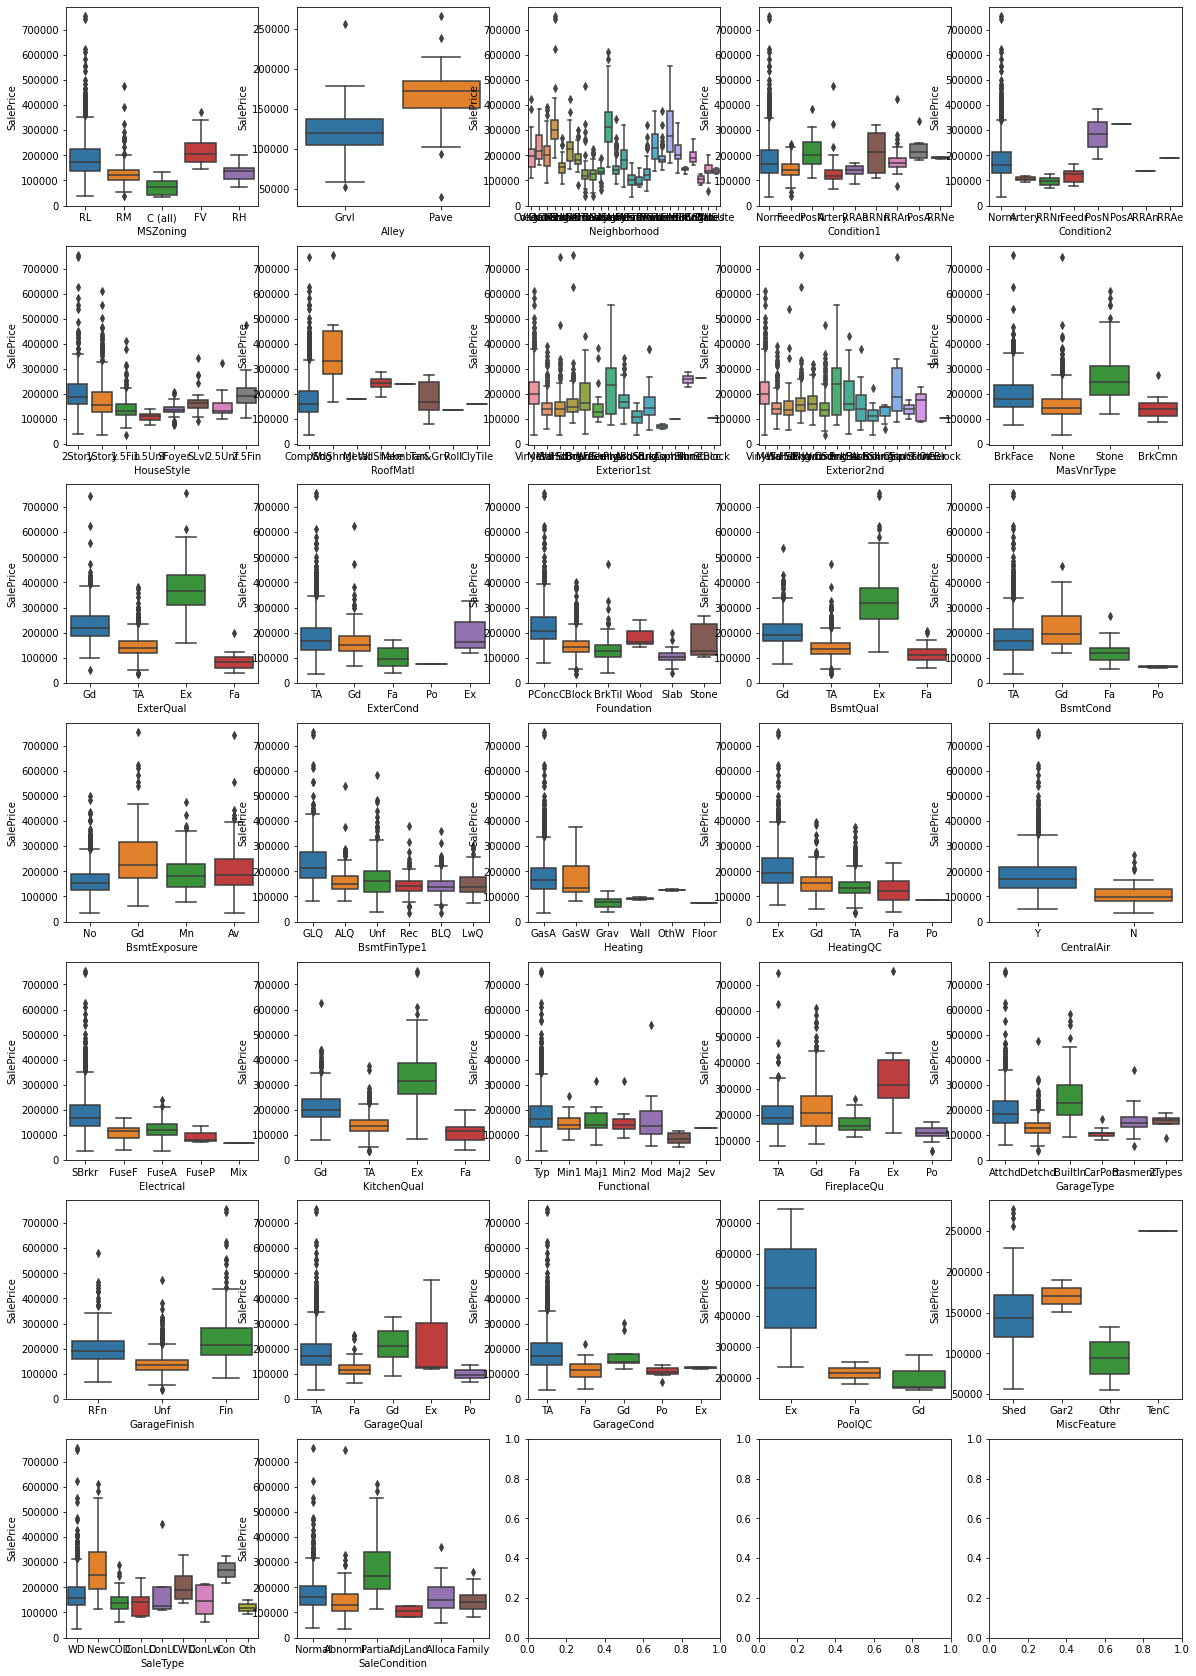

In [7]:
#============== sns.boxplot() --지워졌는지 아닌지 확인용~
object_feature = df.dtypes[df.dtypes == 'object'].index
print(object_feature)
fig, axs = plt.subplots(figsize=(20,30), ncols=5, nrows=7)
for i, feature in enumerate(object_feature):
    row = int(i / 5) 
    col = i % 5
    # seaborn의 regplot 이용하여 박스플롯
    sns.boxplot(x=feature, y='SalePrice', data=df, ax=axs[row][col])

** target(SalePrice)에 영향을 미치는(각 피쳐별로 값의 중앙값의 편차가 크다) 피쳐 선정



● 'SalePrice', 상관성이 높은 피쳐(회귀계수)
    카테고리(object)형 : 
     'MSZoning', 'Neighborhood', 'Condition1', 'Condition2', 'SaleType'

    수치형 : 
     'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
     'YearBuilt', 'TotalBsmtSF', 'FullBath', 'YearRemodAdd', '1stFlrSF',
     'GarageYrBlt', 'TotRmsAbvGrd', 'Fireplaces', 'OpenPorchSF',
     'MasVnrArea'

    *다중공선 해결 

    'GarageCars', 'GarageArea',

    'GrLivArea','TotRmsAbvGrd'

    'GarageYrBlt','YearBuilt'

    '1stFlrSF','TotalBsmtSF'


</pre>


IQR (Inter Quartile Range). IQR 이란 상위 75% 지점의 값과 하위 25 지점의 값 차이를 의미한다.

최솟값 : 제 1사분위에서 1.5 IQR1을 뺀 위치이다.
제 1사분위(Q1) : 25%의 위치를 의미한다.
제 2사분위(Q2) : 50%의 위치로 중앙값(median)을 의미한다.
제 3사분위(Q3) : 75%의 위치를 의미한다.
최댓값 : 제 3사분위에서 1.5 IQR을 더한 위치이다.
최솟값과 최댓값을 넘어가는 위치에 있는 값을 이상치(Outlier)라고 부른다.

In [8]:
# # 아웃라이어 탐지 삭제 --> 안할거야~~~~~~~~~~~~~~~~~~~~~~~~~


# from collections import Counter
# def detect_outliers(df2, features):
#     outlier_idx_list = []
#     for col in features:
#         Q1 = np.percentile(df2[col], 25)
#         Q3 = np.percentile(df2[col], 75)
#         IQR = Q3 - Q1
#         IQR15 = 1.5 * IQR
#         outlier_list_col = df2[(df2[col] < Q1 - IQR15) | (df2[col] > Q3 + IQR15)].index
#         outlier_idx_list.extend(outlier_list_col)
#     outlier_idx_list = Counter(outlier_idx_list)
#     # multiple_outliers = list(k for k, v in outlier_idx_list.items() if v > n)
    
#     return outlier_idx_list

In [9]:
# # numeric_feature --> 전처리 전 숫자형 컬럼들 / numeric_feature2 --> 전처리 후 숫자형 컬럼들
# numeric_feature2 = df2.dtypes[df2.dtypes != 'object'].index

In [10]:
# outlier_drop_feature = detect_outliers(df2, numeric_feature2)
# print(outlier_drop_feature)

# print("Outlier 처리전:", df2.shape)
# df2 = df2.drop(outlier_drop_feature, axis = 0).reset_index(drop=True)
# print("Outlier 처리후:", df2.shape)

In [11]:
# X_train.plot(kind='box', subplots=True, figsize=(30, 20), layout=(5,6), sharex=False, sharey=False)
# plt.show()

In [12]:
# outlier_drop_feature_t = detect_outliers(df2_t, 2, numeric_feature2_t)
# print(outlier_drop_feature)

# print("Outlier 처리전:", df2_t.shape)
# df2_t = df2_t.drop(outlier_drop_feature, axis = 0).reset_index(drop=True)
# print("Outlier 처리후:", df2_t.shape)

# --------------------------

합치기전에 df 한번보자

In [13]:
df.shape

(1460, 70)

In [14]:
df_t.shape

(1459, 69)

In [15]:

data = df.append(df_t)
index = data['Id']
data = data.set_index('Id')
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,Neighborhood,Condition1,Condition2,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,NaN,CollgCr,Norm,Norm,2Story,7,5,2003,2003,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,0,61,0,0,0,0,NaN,NaN,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,NaN,Veenker,Feedr,Norm,1Story,6,8,1976,1976,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,298,0,0,0,0,0,NaN,NaN,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,NaN,CollgCr,Norm,Norm,2Story,7,5,2001,2002,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,0,42,0,0,0,0,NaN,NaN,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,NaN,Crawfor,Norm,Norm,2Story,7,5,1915,1970,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,0,35,272,0,0,0,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,NaN,NoRidge,Norm,Norm,2Story,8,5,2000,2000,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,192,84,0,0,0,0,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,NaN,MeadowV,Norm,Norm,2Story,4,7,1970,1970,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0,0,0,0,0,0,NaN,NaN,0,6,2006,WD,Normal,NaN
2916,160,RM,21.0,1894,NaN,MeadowV,Norm,Norm,2Story,4,5,1970,1970,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,0,24,0,0,0,0,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2917,20,RL,160.0,20000,NaN,Mitchel,Norm,Norm,1Story,5,7,1960,1996,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,474,0,0,0,0,0,NaN,NaN,0,9,2006,WD,Abnorml,NaN


### 2. 결측치 확인/피쳐삭제/채우기
- 대량의 피쳐 분석의 경우 : 결측치 피쳐(컬럼) 삭제부터 => 컬럼이라 test도 같이 지워도 된다.

뒤에서 null값 비율에따라 drop하기 때문에 SalePrice를 일단 평균값을 채워준다. 

In [16]:
data['SalePrice'].fillna(data['SalePrice'].mean(), inplace=True)
data['SalePrice'].replace(np.nan, 'None', inplace=True)

In [17]:
# ---------- dataframe 결측치 확인/제거
def null_feature_check(data_f, drop_cnt=None):
    isnull_feature = data_f.isnull().sum()[data_f.isnull().sum()>0].index
    null_df = pd.DataFrame()
    null_df["null_cnt"]  = data_f[isnull_feature].isnull().sum()
    null_df["null_rate"]  = data_f[isnull_feature].isnull().sum() /data_f.shape[0] * 100
    print(null_df)

    # FireplaceQu     690 47.260274  --- 모델 평가 후 재검토 필요
    
    if drop_cnt != None :
        drop_isnull_feature = data_f.isnull().sum()[data_f.isnull().sum() > drop_cnt].index
        #['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
        
        print("\ndrop_feature:",drop_isnull_feature)

        # df.drop(drop_isnull_feature, axis=1, inplace=True)
        data_f = data_f.drop(drop_isnull_feature, axis=1)
        print(data_f.shape)  #(1460, 76)
    return data_f

data = null_feature_check(data, 600)

              null_cnt  null_rate
MSZoning             4   0.137033
LotFrontage        486  16.649538
Alley             2721  93.216855
Exterior1st          1   0.034258
Exterior2nd          1   0.034258
MasVnrType          24   0.822199
MasVnrArea          23   0.787941
BsmtQual            81   2.774923
BsmtCond            82   2.809181
BsmtExposure        82   2.809181
BsmtFinType1        79   2.706406
BsmtFinSF1           1   0.034258
BsmtFinSF2           1   0.034258
BsmtUnfSF            1   0.034258
TotalBsmtSF          1   0.034258
Electrical           1   0.034258
BsmtFullBath         2   0.068517
BsmtHalfBath         2   0.068517
KitchenQual          1   0.034258
Functional           2   0.068517
FireplaceQu       1420  48.646797
GarageType         157   5.378554
GarageYrBlt        159   5.447071
GarageFinish       159   5.447071
GarageCars           1   0.034258
GarageArea           1   0.034258
GarageQual         159   5.447071
GarageCond         159   5.447071
PoolQC        

In [18]:
# ---------- train 결측치 채우기 / 최종확인
# objct_type_fillna(df, object_feature)
# numeric_type_fillna(df, numeric_feature)
data.fillna(data.mean(), inplace=True)
data.replace(np.nan, 'None', inplace=True)
data = null_feature_check(data)

Empty DataFrame
Columns: [null_cnt, null_rate]
Index: []


In [19]:
#확인용

data[['BsmtFinSF2', 'BsmtFinSF1']].isnull().sum()

BsmtFinSF2    0
BsmtFinSF1    0
dtype: int64

### 3. 수치형 피쳐 데이터값 확인

In [20]:
object_feature, numeric_feature = type_check(df)

int64      35
object     32
float64     3
dtype: int64
object type: Index(['MSZoning', 'Alley', 'Neighborhood', 'Condition1', 'Condition2',
       'HouseStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
numeric type: Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'Gar

In [21]:
numeric_feature = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

In [22]:
data[numeric_feature].head(10).T

Id,1,2,3,4,5,6,7,8,9,10
MSSubClass,60.0,20.0,60.0,70.0,60.0,50.0,20.0,60.000000,50.0,190.0
LotFrontage,65.0,80.0,68.0,60.0,84.0,85.0,75.0,69.305795,51.0,50.0
LotArea,8450.0,9600.0,11250.0,9550.0,14260.0,14115.0,10084.0,10382.000000,6120.0,7420.0
OverallQual,7.0,6.0,7.0,7.0,8.0,5.0,8.0,7.000000,7.0,5.0
OverallCond,5.0,8.0,5.0,5.0,5.0,5.0,5.0,6.000000,5.0,6.0
YearBuilt,2003.0,1976.0,2001.0,1915.0,2000.0,1993.0,2004.0,1973.000000,1931.0,1939.0
YearRemodAdd,2003.0,1976.0,2002.0,1970.0,2000.0,1995.0,2005.0,1973.000000,1950.0,1950.0
MasVnrArea,196.0,0.0,162.0,0.0,350.0,0.0,186.0,240.000000,0.0,0.0
BsmtFinSF1,706.0,978.0,486.0,216.0,655.0,732.0,1369.0,859.000000,0.0,851.0
BsmtFinSF2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.000000,0.0,0.0


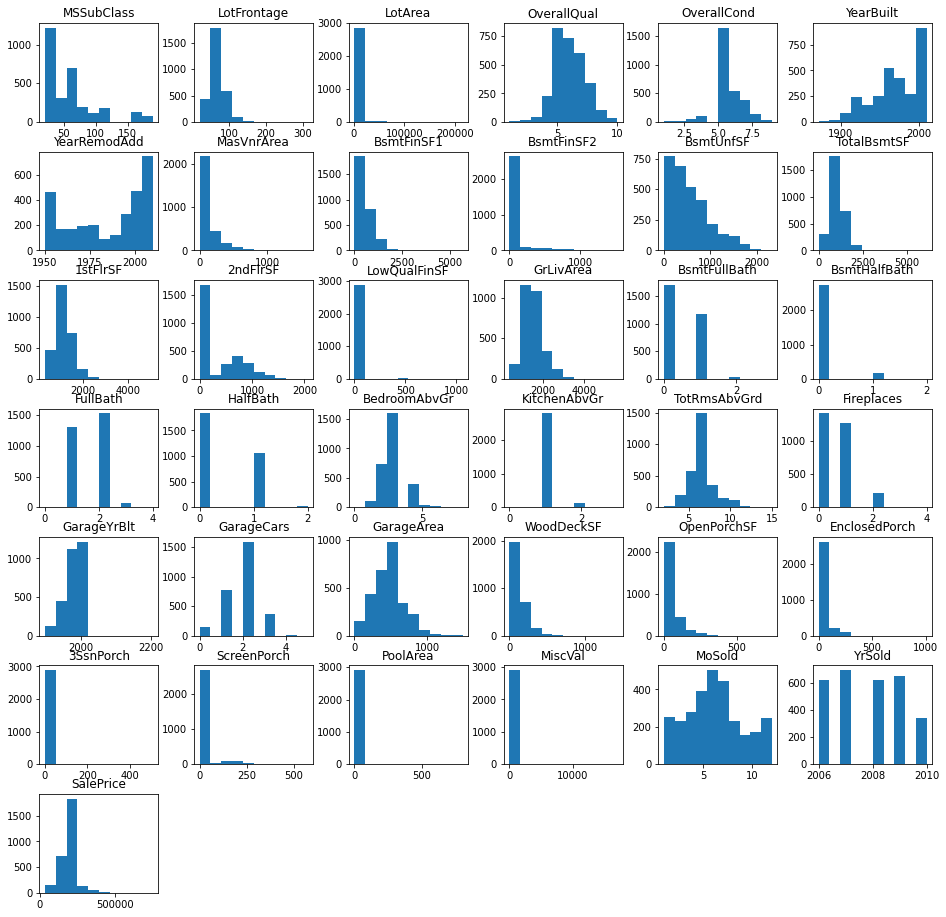

In [23]:
data.hist(bins=10, figsize=(16,16), grid=False);
plt.show()

unique ID 피쳐 삭제 --> Id를 인덱스로 사용 중이라 삭제하지 않는다.

In [24]:
# data.drop('Id', axis=1, inplace=True)


# numeric_feature = df.dtypes[df.dtypes != 'object'].index  #pandas.core.indexes.base.Index
# print(numeric_feature)

# #-------------------------------

# df_t.drop('Id', axis=1, inplace=True)


# numeric_feature_t = df_t.dtypes[df_t.dtypes != 'object'].index  #pandas.core.indexes.base.Index
# print(numeric_feature_t)

In [25]:
data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Neighborhood',
       'Condition1', 'Condition2', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition',
       'SalePrice']

### 7. Object형 시각화

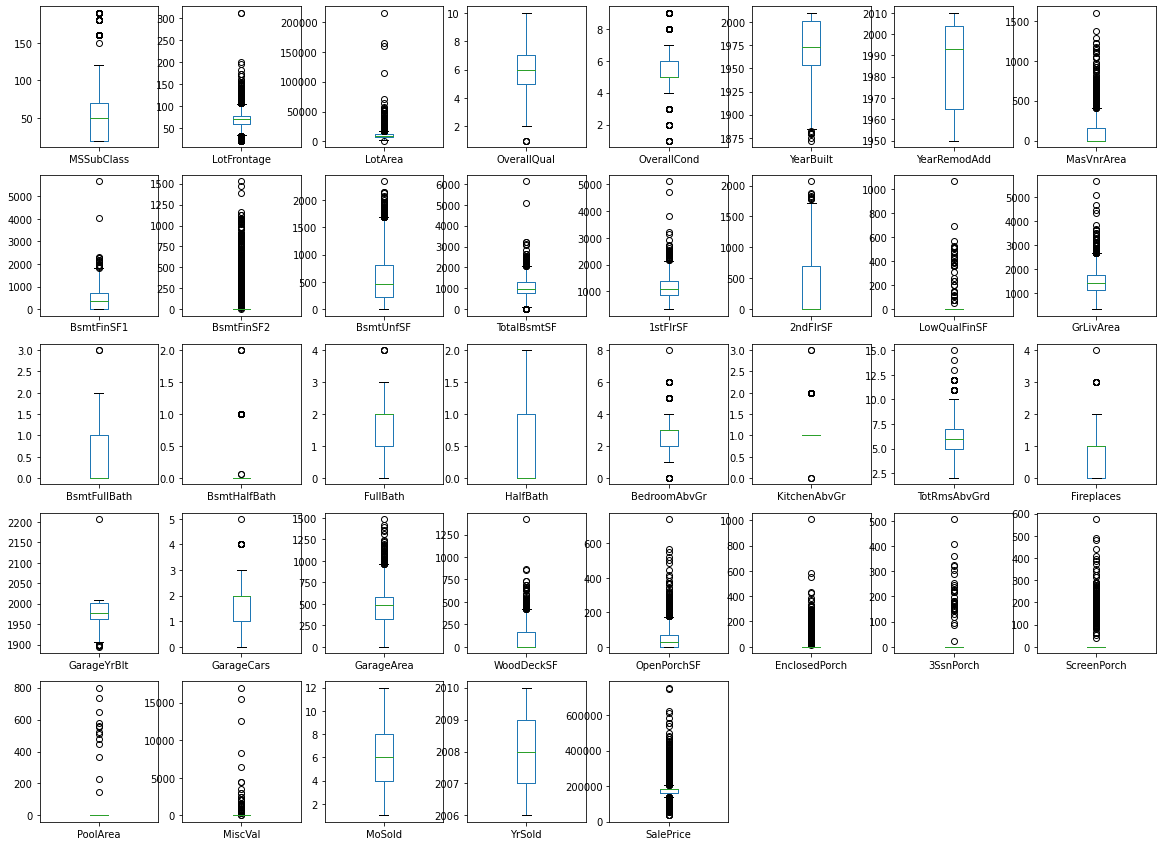

In [26]:
#============== matplot.plt(box) (확인용)
data.plot(kind='box', subplots=True, figsize=(20, 15), layout=(5,8), sharex=False, sharey=False)
plt.show()

In [27]:
outlier_list = ['BsmtFinSF2']
#BsmtFinSF2  아웃라이어 값이 전체이므로 삭제처리

data = data.drop(outlier_list, axis=1)

#boxplot 확인 결과 아웃라이어가 너무 많아서 삭제처리 할 내용들을 list에 담기

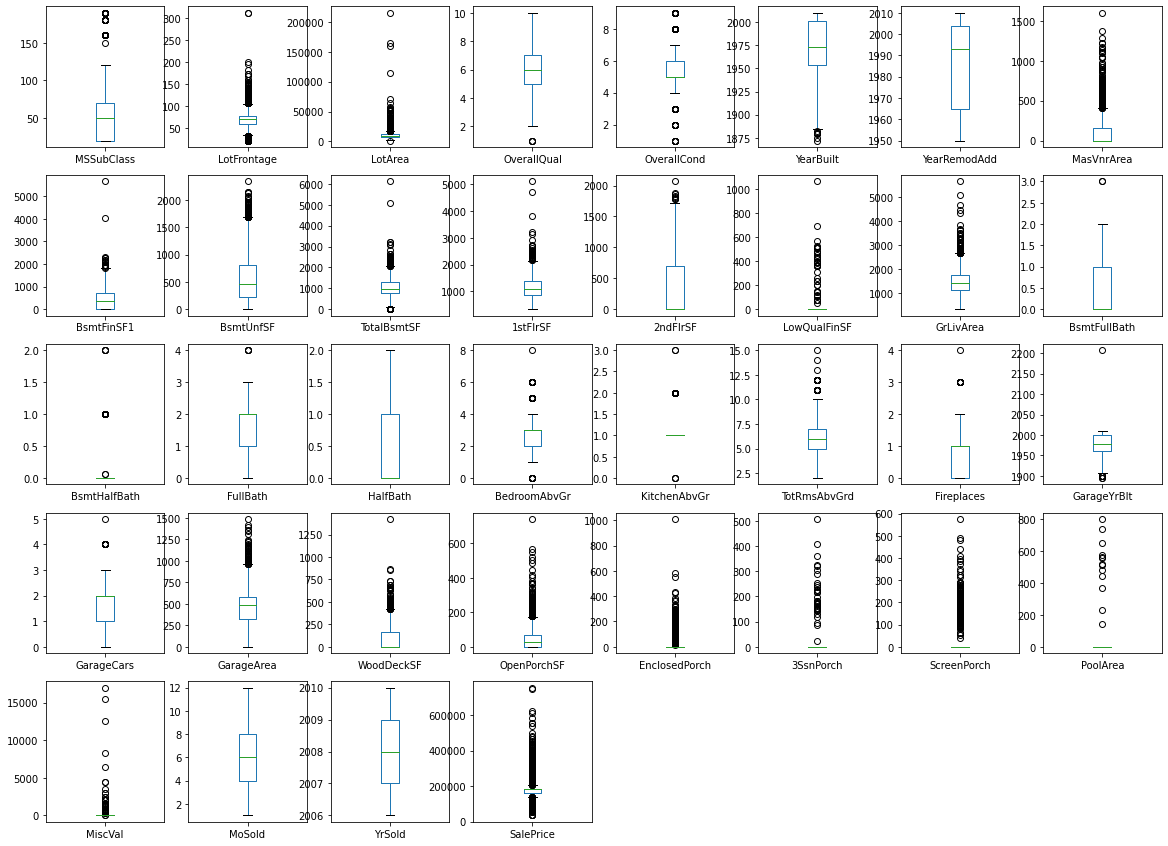

In [28]:
#============== matplot.plt(box) (확인용)
# df2 ==> df복사본~
data.plot(kind='box', subplots=True, figsize=(20, 15), layout=(5,8), sharex=False, sharey=False)
plt.show()

### 4. 숫자 모양의 object형 피쳐 인코딩

In [29]:
object_feature, numeric_feature = type_check(data)

object     28
int64      25
float64    11
dtype: int64
object type: Index(['MSZoning', 'Neighborhood', 'Condition1', 'Condition2', 'HouseStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'SaleType', 'SaleCondition'],
      dtype='object')
numeric type: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch',

원-핫 인코딩은 간단히 말해 한 개의 요소는 True, 나머지 요소는 False로 만들어 주는 기법이다.

※ 원-핫 인코딩이 필요한 이유?
scikit-learn에서 제공하는 머신러닝 알고리즘은 문자열 값을 입력 값으로 허락하지 않기 때문에 모든 문자열 값들을 숫자형으로 인코딩하는 전처리 작업(Preprocessing) 후에 머신러닝 모델에 학습을 시켜야 한다.

scikit-learn 에서 제공하는 머신러닝 알고리즘에 데이터를 넣을 수 있는 기본 조건은 다음과 같다.
– 모든 데이터는 숫자(정수형, 실수형 등)로 구성되어 있어야 한다.
– 데이터에 빈 값이 없어야 한다.

In [30]:
# select distinct deptno from emp;
#수치형 : 0/1/2 코드성 수치
oh_numeric_feature = []
for col in numeric_feature:
    if data[col].nunique() <= 15:
        print(col, data[col].unique())
        oh_numeric_feature.append(col)
print("인코딩 적용 전 :",data.shape)

oh_numeric_feature.remove('PoolArea')
print("인코딩 대상 피쳐 :", oh_numeric_feature)

data_oh = pd.get_dummies(data=data, columns=oh_numeric_feature)
print("인코딩 적용 후 :",data_oh.shape)
print(data_oh.head())

OverallQual [ 7  6  8  5  9  4 10  3  1  2]
OverallCond [5 8 6 7 4 2 3 9 1]
BsmtFullBath [1.         0.         2.         3.         0.42989373]
BsmtHalfBath [0.         1.         2.         0.06136442]
FullBath [2 1 3 0 4]
HalfBath [1 0 2]
BedroomAbvGr [3 4 1 2 0 5 6 8]
KitchenAbvGr [1 2 3 0]
TotRmsAbvGrd [ 8  6  7  9  5 11  4 10 12  3  2 14 13 15]
Fireplaces [0 1 2 3 4]
GarageCars [2.         3.         1.         0.         4.         5.
 1.76662097]
PoolArea [  0 512 648 576 555 480 519 738 144 368 444 228 561 800]
MoSold [ 2  5  9 12 10  8 11  4  1  7  3  6]
YrSold [2008 2007 2006 2009 2010]
인코딩 적용 전 : (2919, 64)
인코딩 대상 피쳐 : ['OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']
인코딩 적용 후 : (2919, 142)
    MSSubClass MSZoning  LotFrontage  ...  YrSold_2008 YrSold_2009 YrSold_2010
Id                                    ...                                  

In [31]:
object_feature, numeric_feature = type_check(data_oh)

uint8      91
object     28
int64      15
float64     8
dtype: int64
object type: Index(['MSZoning', 'Neighborhood', 'Condition1', 'Condition2', 'HouseStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'SaleType', 'SaleCondition'],
      dtype='object')
numeric type: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       ...
       'MoSold_8', 'MoSold_9', 'MoSold_10', 'MoSold_11', 'MoSold_12',
       'YrSold_2006', 'YrSold_2007', 'YrSold_2008', 'YrSold_2009',
       'YrSold_2010'],
      dtype='object', length=114)


- nunique가 15개보다 작다는것은 숫자로 된 범주형일 확률이 높다는 뜻이다. => 범주형 찾아서 원핫인코딩
- 다만, 그 안에서도 범주형으로 보기 애매한게 있을 수 있으므로 주의해야 한다.

### 6. 수치형 정규화
타켓 분포도 확인/정규화

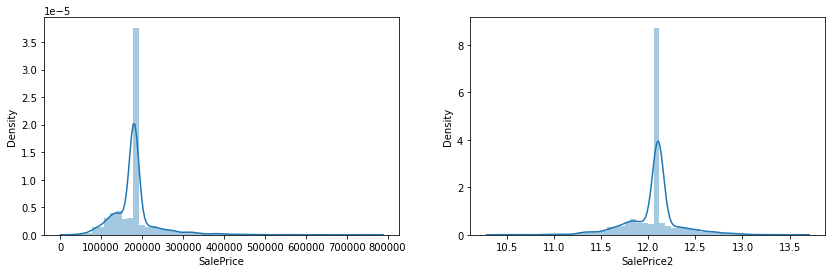

In [32]:
# MinMaxScaler: 0 ~ 1
# StandardScaler: 평균0 분산1(정규분포)
# np.log()
#  : max을 0으로두고 다른값을 뺀 그 차이값을 이용
# np.log1p()
# : log를 취한값이 너무 작으면 언더플로우가 나기 때문에 1을 더해서 사용

data_oh['SalePrice2'] = np.log1p(data_oh['SalePrice'])

f, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
sns.distplot(data_oh['SalePrice'],  ax=axes[0])
sns.distplot(data_oh['SalePrice2'], ax=axes[1])
plt.show()

수치형 피쳐 : skew() kurt() 왜도/첨도확인

왜도(비대칭도)란, 확률변수의 확률분포가 비대칭성을 의미한다
a=0이면 정규분포, a<0이면 오른쪽으로 치우침, a>0이면 왼쪽으로 치우침을 의미한다.

첨도란(Kurtosis), 확률분포의 뾰족한 정도를 의미한다
a=3이면 정규분포, a<3이면 정규분포보다 완만함, a>3이면 정규분포 보다 뾰족함을 의미한다.

In [33]:
#============== skew() kurt() 왜도/첨도 확인
sk_df = pd.DataFrame()

# sns.distplot(df[col])
#왜도 : 대칭=0(정규분포) <0 :오른쪽편중  >0:왼쪽편중
sk_df["skew"] = data_oh[numeric_feature].skew()
#첨도 : 뾰족함(중앙 편중)
sk_df["kurt"] = data_oh[numeric_feature].kurt()
print(sk_df.head(40).sort_values("skew", ascending=False))

                     skew        kurt
OverallQual_1   26.972189  725.996401
MiscVal         21.958480  564.074582
OverallCond_1   20.357512  412.711059
OverallCond_2   17.005900  287.397544
PoolArea        16.907017  298.633144
OverallQual_2   14.891972  219.921516
LotArea         12.829025  264.952310
LowQualFinSF    12.094977  174.932812
3SsnPorch       11.381914  149.409834
OverallQual_10   9.553314   89.327015
OverallQual_3    8.370238   68.107555
OverallCond_3    7.446772   53.491064
OverallCond_4    5.095440   23.979942
OverallQual_9    4.933907   22.358760
EnclosedPorch    4.005950   28.377909
ScreenPorch      3.948723   17.776704
OverallQual_4    3.163880    8.015629
SalePrice        2.660964   16.042632
MasVnrArea       2.612892    9.351548
OpenPorchSF      2.536417   10.937353
OverallQual_8    2.381938    3.676149
OverallCond_7    2.154901    2.645411
WoodDeckSF       1.843380    6.741550
OverallCond_6    1.649950    0.722829
LotFrontage      1.646420   14.147063
1stFlrSF    

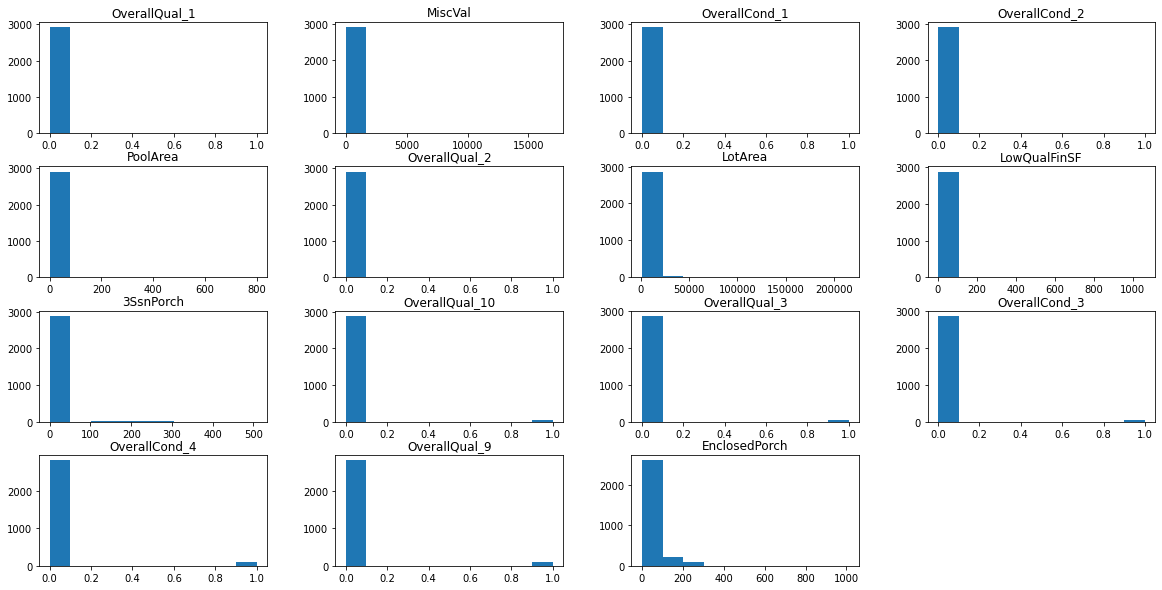

In [34]:
skew_feature = sk_df.head(40).sort_values("skew", ascending=False)[:15].index
#skew_feature = skew_feature # - oh_numeric_feature

data_oh[skew_feature].hist(bins=10, figsize=(20,10), grid=False)
plt.show()

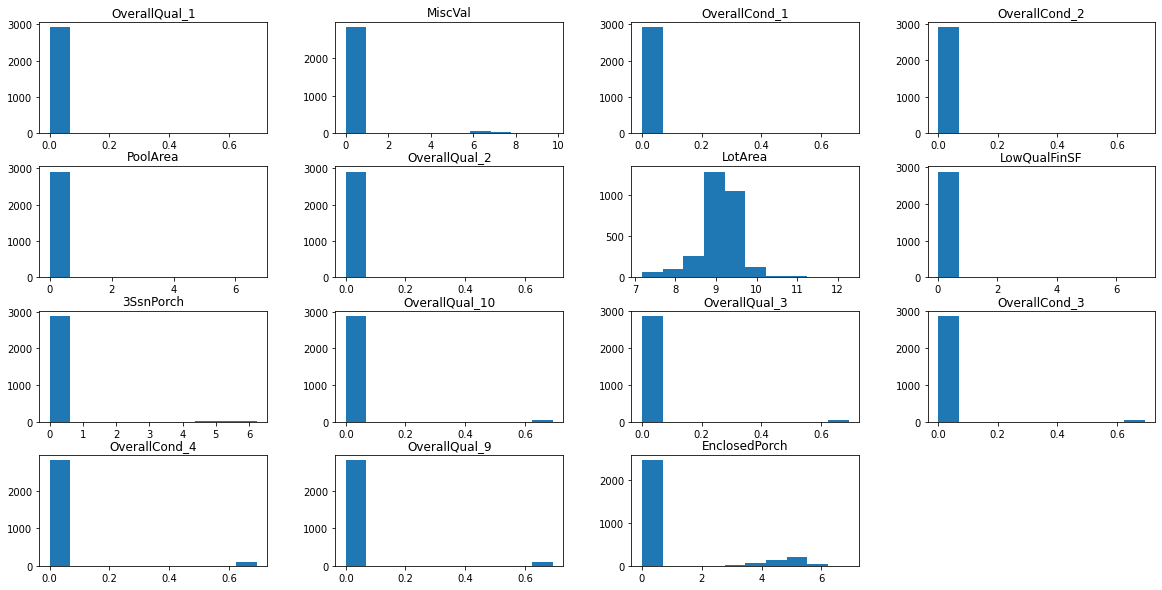

In [35]:
for col in skew_feature:
    data_oh[col] = np.log1p(data_oh[col]) #그냥 log보다 log1p는 엄청 작은 값도 잡아준다.
data_oh[skew_feature].hist(bins=10, figsize=(20,10), grid=False)
plt.show()

In [36]:
# BsmtFinSF1 : BsmtUnitSF : BstmtFullBath
# YearBuiltin : EnclosedPoach

# taget 피쳐와 상관관계가 가장 높은 피쳐들을 확인 --> 시각화
# taget 피쳐를 제외한 모든 수치형 피쳐들간에 상관관계  --> 다중공선없엔다(drop대상)

### 9. Object형 피쳐 인코딩

- 만약 시작할 때 train test를 안 합친 경우에는 인코딩 전 test와 train 합치기 ! 
- pd.get_dummy() --> dummy는 행을 열에 늘리는 거니까 train하고 test하고 행이 다른 상황이라 합쳐서 더미를 하고 나눠야 하기 때문

In [37]:
# Object Type : 
# LabelEncoding (Pool Extend ... Excellent : 0 1 ... 33)
# OneHotEncoding (1000 0100  0010 0001) :피쳐가 엄청~ 많아진다(시각화X, 분석용)


# pd.get_dummy() --> dummy는 행을 열에 늘리는 거니까 train하고 test하고 행이 다른 상황이라 합쳐서 더미를 하고 나눠야 한다.

print("인코딩 적용 전 :",data_oh.shape)
data_oh = pd.get_dummies(data=data_oh, columns=object_feature)
print("인코딩 적용 후 :",data_oh.shape)

인코딩 적용 전 : (2919, 143)
인코딩 적용 후 : (2919, 324)


-------------------------------------------------------------

In [38]:
X_train = data_oh[:1460]
X_test = data_oh[1460:]

In [39]:
X_train

,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,OverallQual_1,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,...,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_None,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,9.042040,2003,2003,196.0,706.0,150.0,856.0,856,854,0.0,1710,2003.0,548.0,0,61,0.000000,0.0,0,0.0,0.000000,208500.0,0.0,0.0,0.0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,20,80.0,9.169623,1976,1976,0.0,978.0,284.0,1262.0,1262,0,0.0,1262,1976.0,460.0,298,0,0.000000,0.0,0,0.0,0.000000,181500.0,0.0,0.0,0.0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,60,68.0,9.328212,2001,2002,162.0,486.0,434.0,920.0,920,866,0.0,1786,2001.0,608.0,0,42,0.000000,0.0,0,0.0,0.000000,223500.0,0.0,0.0,0.0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,70,60.0,9.164401,1915,1970,0.0,216.0,540.0,756.0,961,756,0.0,1717,1998.0,642.0,0,35,5.609472,0.0,0,0.0,0.000000,140000.0,0.0,0.0,0.0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
5,60,84.0,9.565284,2000,2000,350.0,655.0,490.0,1145.0,1145,1053,0.0,2198,2000.0,836.0,192,84,0.000000,0.0,0,0.0,0.000000,250000.0,0.0,0.0,0.0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,8.976894,1999,2000,0.0,0.0,953.0,953.0,953,694,0.0,1647,1999.0,460.0,0,40,0.000000,0.0,0,0.0,0.000000,175000.0,0.0,0.0,0.0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1457,20,85.0,9.486152,1978,1988,119.0,790.0,589.0,1542.0,2073,0,0.0,2073,1978.0,500.0,349,0,0.000000,0.0,0,0.0,0.000000,210000.0,0.0,0.0,0.0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1458,70,66.0,9.109746,1941,2006,0.0,275.0,877.0,1152.0,1188,1152,0.0,2340,1941.0,252.0,0,60,0.000000,0.0,0,0.0,7.824446,266500.0,0.0,0.0,0.0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [40]:
X_test

,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,OverallQual_1,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,...,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_None,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,80.0,9.360741,1961,1961,0.0,468.0,270.0,882.0,896,0,0.0,896,1961.000000,730.0,140,0,0.0,0.0,120,0.0,0.000000,180921.19589,0.0,0.0,0.0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,...,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1462,20,81.0,9.565775,1958,1958,108.0,923.0,406.0,1329.0,1329,0,0.0,1329,1958.000000,312.0,393,36,0.0,0.0,0,0.0,9.433564,180921.19589,0.0,0.0,0.0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,...,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1463,60,74.0,9.534668,1997,1998,0.0,791.0,137.0,928.0,928,701,0.0,1629,1997.000000,482.0,212,34,0.0,0.0,0,0.0,0.000000,180921.19589,0.0,0.0,0.0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1464,60,78.0,9.208238,1998,1998,20.0,602.0,324.0,926.0,926,678,0.0,1604,1998.000000,470.0,360,36,0.0,0.0,0,0.0,0.000000,180921.19589,0.0,0.0,0.0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,...,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1465,120,43.0,8.518392,1992,1992,0.0,263.0,1017.0,1280.0,1280,0,0.0,1280,1992.000000,506.0,0,82,0.0,0.0,144,0.0,0.000000,180921.19589,0.0,0.0,0.0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,21.0,7.568896,1970,1970,0.0,0.0,546.0,546.0,546,546,0.0,1092,1978.113406,0.0,0,0,0.0,0.0,0,0.0,0.000000,180921.19589,0.0,0.0,0.0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,...,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2916,160,21.0,7.546974,1970,1970,0.0,252.0,294.0,546.0,546,546,0.0,1092,1970.000000,286.0,0,24,0.0,0.0,0,0.0,0.000000,180921.19589,0.0,0.0,0.0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2917,20,160.0,9.903538,1960,1996,0.0,1224.0,0.0,1224.0,1224,0,0.0,1224,1960.000000,576.0,474,0,0.0,0.0,0,0.0,0.000000,180921.19589,0.0,0.0,0.0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,...,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0


In [41]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Columns: 324 entries, MSSubClass to SaleCondition_Partial
dtypes: float16(9), float64(15), int64(9), uint8(291)
memory usage: 725.7 KB


In [42]:
X_test = X_test.drop(['SalePrice','SalePrice2'], axis=1)

### 10. 학습모델 선정 / 평가

In [45]:
y_log = X_train['SalePrice2']
y = X_train['SalePrice']
train = X_train.drop(['SalePrice','SalePrice2'], axis=1)

# ---- 데이터 셋 ------------------------
X_train, X_val, y_train, y_val = train_test_split(train, y_log, test_size=0.3, random_state=11)

In [46]:
# ---- 개별 분류 모델 -------------------
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()

for model_name, model in [("LR", lr), ("Ridge", ridge), ("Lasso", lasso)]:
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    print(model_name , mean_squared_error(y_val, pred))

LR 0.02653175488693016
Ridge 0.017603802576243697
Lasso 0.025892807760247872


In [47]:
#----- cross_val_score-------

for model_name, model in [("LR", lr), ("Ridge", ridge), ("Lasso", lasso)]:
    neg_mse_scores = cross_val_score(model, train, y_log, scoring="neg_mean_squared_error", cv = 5)
    rmse_scores  = np.sqrt(-1 * neg_mse_scores) #차이를 극대화해서 보려고 neg를 쓰므로 -1해서 양수로 바꿔야함
    avg_rmse = np.mean(rmse_scores)
    print(model_name, ' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
    print(model_name, ' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores,3))
    print(model_name, ' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))
    print()

LR  5 folds 의 개별 Negative MSE scores:  [-0.018 -0.026 -0.029 -0.015 -0.039]
LR  5 folds 의 개별 RMSE scores :  [0.133 0.162 0.171 0.123 0.198]
LR  5 folds 의 평균 RMSE : 0.158 

Ridge  5 folds 의 개별 Negative MSE scores:  [-0.013 -0.024 -0.02  -0.015 -0.035]
Ridge  5 folds 의 개별 RMSE scores :  [0.115 0.155 0.142 0.123 0.188]
Ridge  5 folds 의 평균 RMSE : 0.145 

Lasso  5 folds 의 개별 Negative MSE scores:  [-0.027 -0.041 -0.032 -0.033 -0.07 ]
Lasso  5 folds 의 개별 RMSE scores :  [0.163 0.203 0.178 0.182 0.265]
Lasso  5 folds 의 평균 RMSE : 0.198 



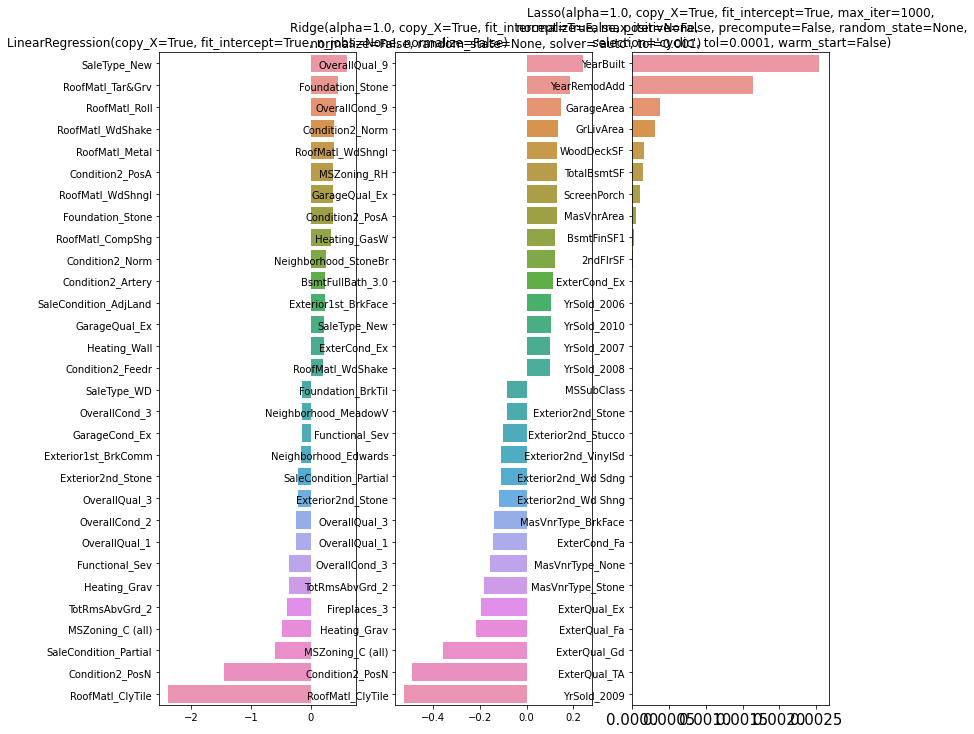

In [48]:
# 각 모델에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
models = [lr, ridge, lasso]
    
fig , axs = plt.subplots(figsize=(12,12) , nrows=1 , ncols=3)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성  
coef_df = pd.DataFrame()
plt.xticks(fontsize=15)

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos , model in enumerate(models) :
    model.fit(X_train, y_train)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가.  
    coef = pd.Series(data=model.coef_ , index=X_train.columns )
    coef_head = coef.sort_values(ascending=False).head(15)
    coef_tail = coef.sort_values(ascending=False).tail(15)
    coef = pd.concat([coef_head, coef_tail])
    coef_df[model] = coef
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현--------------------추가코드
    coef = coef.sort_values(ascending=False)
    axs[pos].set_title(model)
    
#     axs[pos].set_xlim(-0.2,0.2)
    sns.barplot(x=coef.values , y=coef.index, ax=axs[pos])
# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시

plt.show()

### 13.모델 검증 및 튜닝

In [49]:
myprm = {'alpha':[0.05,0.1,0.5,1.0,3.0,10.0, 20.0]}
best_model = GridSearchCV(ridge, param_grid=myprm,
             scoring="neg_mean_squared_error",verbose=0,
             refit=True, cv=5)
best_model.fit(X_train, y_train)
print("베스트 점수:",best_model.best_score_)
print("베스트 파라미터:",best_model.best_params_)

best_pred = best_model.predict(X_test)
# mse = mean_squared_error(y_test3, best_pred)
# print(mse, np.sqrt(mse))

베스트 점수: -0.025360225734104246
베스트 파라미터: {'alpha': 1.0}


- best_param 중심으로 튜닝 값 재조정
- alpha값 변화를 시각화해서 확인

In [50]:
print("submit시 제출할 예측 집값(로그변환값) :\n", best_pred[:5])
print("원본값으로 변환:\n", np.round(np.expm1(best_pred),0)[:5])

submit시 제출할 예측 집값(로그변환값) :
 [11.7327113  11.9122074  12.1143003  12.22236489 12.18604189]
원본값으로 변환:
 [124580. 149074. 182462. 203284. 196033.]


In [51]:
myprm = [1.0, 1,5,8.0,9.0,10.0,11.0,12.0,15,20,50]
score_list = []
for ap in myprm:
    ridge = Ridge(alpha=ap)
    neg_mse_scores5 = cross_val_score(ridge, train, y_log, 
                scoring="neg_mean_squared_error", cv = 5)
    rmse_scores5  = np.sqrt(-1 * neg_mse_scores5)
    avg_rmse = np.mean(rmse_scores5)
    print(avg_rmse)  
    score_list.append(avg_rmse)

0.14471016473439707
0.14471016473439707
0.1402848930272313
0.14018478169189696
0.14027225220603046
0.14038911963431905
0.1405261770913397
0.1406771918954942
0.141176757622847
0.14205825181369675
0.1467171820164689


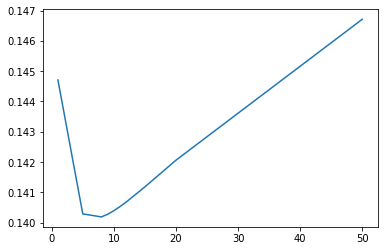

In [52]:
plt.plot(myprm, score_list)
plt.show()

In [54]:
sub_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/price_submission.csv")
mydic = {"Id": sub_df["Id"],
         "SalePrice" : np.round(np.expm1(best_pred),0)
         }
sub_df = pd.DataFrame(mydic, index=None)
print(sub_df.head())
sub_df.to_csv("sample_submission22.csv", index=None)

     Id  SalePrice
0  1461   124580.0
1  1462   149074.0
2  1463   182462.0
3  1464   203284.0
4  1465   196033.0


In [61]:
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression
from sklearn.pipeline import make_pipeline

In [62]:
param_e = {'alpha' :[0.1,1.0,10], 'max_iter' :[1000000], 'l1_ratio':[0.04,0.05], 'normalize':[True,False]}

In [63]:
def rmsle_score(preds, true):
    rmsle_score = (np.sum((np.log1p(preds)-np.log1p(true))**2)/len(true))**0.5
    return rmsle_score

In [64]:
from sklearn.metrics.scorer import make_scorer

RMSLE = make_scorer(rmsle_score)

In [65]:
Enet = make_pipeline(GridSearchCV(ElasticNet(random_state=1),param_e,cv=10, scoring = RMSLE))

In [66]:
Enet.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('gridsearchcv',
                 GridSearchCV(cv=10, error_score=nan,
                              estimator=ElasticNet(alpha=1.0, copy_X=True,
                                                   fit_intercept=True,
                                                   l1_ratio=0.5, max_iter=1000,
                                                   normalize=False,
                                                   positive=False,
                                                   precompute=False,
                                                   random_state=1,
                                                   selection='cyclic',
                                                   tol=0.0001,
                                                   warm_start=False),
                              iid='deprecated', n_jobs=None,
                              param_grid={'alpha': [0.1, 1.0, 10],
                                          'l1_ratio': [0.04, 0

In [ ]:
# Enet_yhat = Enet.predict(X_val)

In [68]:
pred_Enet = Enet.predict(X_test)

In [69]:
print("submit시 제출할 예측 집값(로그변환값) :\n", pred_Enet[:5])
print("원본값으로 변환:\n", np.round(np.expm1(pred_Enet),0)[:5])

submit시 제출할 예측 집값(로그변환값) :
 [12.0274403 12.0274403 12.0274403 12.0274403 12.0274403]
원본값으로 변환:
 [167282. 167282. 167282. 167282. 167282.]


In [71]:
sub_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/price_submission.csv")
mydic = {"Id": sub_df["Id"],
         "SalePrice" : np.round(np.expm1(pred_Enet),0)
         }
sub_df = pd.DataFrame(mydic, index=None)
print(sub_df.head())
sub_df.to_csv("sample_submission33.csv", index=None)

     Id  SalePrice
0  1461   167282.0
1  1462   167282.0
2  1463   167282.0
3  1464   167282.0
4  1465   167282.0
